# Experimental
Notebook to generate * associated supplementary results

## Reqs

In order to run this notebook you have to download / get following file in addition to the files already present in the repository :
- `data/cmc/cmc_mutation_context.csv`
- `data/clinvar/clinvar_mutation_context.csv`

In [2]:
import polars as pl
from pathlib import Path
from utils import load_data, utils
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

GENERATE_RESULTS = (
    True  # if set to true it will generate results in outputs/ directory.
)
PROJECT_DIR = Path().absolute().parent

In [37]:
def compute_correlation(aggregated, category_col, categories):
    """Pearson correlation between F and vip for each category."""
    return utils.get_table_of_corr(
        aggregated.with_columns(pl.lit("_").alias("db")),
        categories=("db", ["_"]),
        sub_categories=(category_col, categories),
        corr_method=stats.pearsonr,
    )


def compute_corrected_correlation(aggregated, category_col, categories):
    """Partial correlation between F and vip, controlling for GC content of context."""
    agg_gc = aggregated.with_columns(
        pl.col("context")
        .map_elements(lambda ctx: sum(1 for c in ctx if c in "GC"), return_dtype=pl.Int32)
        .alias("gc_count")
    )
    return pl.DataFrame([
        {
            category_col: cat,
            **dict(zip(
                ["partial_r", "p_value"],
                utils.partial_correlation(
                    agg_gc.filter(pl.col(category_col) == cat),
                    "F", "vip", "gc_count",
                    stat_method=stats.pearsonr,
                ),
            )),
        }
        for cat in categories
    ])


def plot_scatter(aggregated, hue):
    """Scatter plot of vip vs F coloured by category."""
    fig, ax = plt.subplots()
    sns.scatterplot(data=aggregated.to_pandas(), x="vip", y="F", hue=hue, ax=ax)
    plt.show()
    return fig


def run_analysis(df, kmer, context_col, category_col, categories):
    """Aggregate counts, print correlations and scatter for one (df, kmer) combination."""
    aggregated = utils.aggregate_data(
        df.group_by([category_col, context_col]).len(),
        kmer,
        on=[category_col, "context"],
        over=[category_col],
        context_col=context_col,
    )
    print("Correlation")
    utils.print_markdown(compute_correlation(aggregated, category_col, categories))
    print("Corrected correlation")
    utils.print_markdown(compute_corrected_correlation(aggregated, category_col, categories))
    plot_scatter(aggregated, category_col)
    return aggregated

## Load data

In [50]:
cmc = pl.read_csv(
    PROJECT_DIR / "data" / "cmc" / "cmc_mutation_context.csv",
    separator=";",
    schema_overrides={"chromosome": pl.Utf8},
).group_by(["chromosome", "position", "ref", "alt"]).first()
cmc_df = cmc.with_columns(
    pl.col("context").str.slice(4, 3).alias("3N"),
    pl.col("context").str.slice(3, 5).alias("5N"),
    pl.lit('cmc').alias('db'),
    pl.when(pl.col.type == pl.lit("Other"))
    .then(pl.lit("passenger"))
    .otherwise(pl.lit("driver"))
    .alias("driver"),
)
pathogenicity_map = {"Likely_benign": "Benign", "Likely_pathogenic": "Pathogenic"}

clinvar = pl.read_csv(
    PROJECT_DIR / "data" / "clinvar" / "clinvar_mutation_context.csv", separator=";"
)
clinvar_df = (
    clinvar.filter(pl.col("impact") != "Uncertain_significance").with_columns(
        pl.col("context").str.slice(4, 3).alias("3N"),
        pl.col("context").str.slice(3, 5).alias("5N"),
        pl.col("impact").replace_strict(pathogenicity_map, default=pl.col('impact')),
        pl.lit('clinvar').alias('db')
    )
)

kmer3 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 3)["context", "frequencies"]
kmer5 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 5)["context", "frequencies"]

## Triplicate

Correlation
| driver    |     _ |
|-----------|-------|
| driver    | -0.69 |
| passenger | -0.8  |
Corrected correlation
| driver    |   partial_r |   p_value |
|-----------|-------------|-----------|
| driver    |       -0.52 |         0 |
| passenger |       -0.58 |         0 |


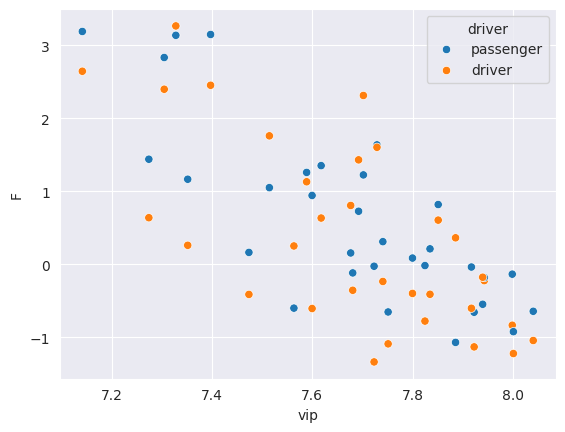

driver,context,count,vip,freq,frequencies,F
str,str,u32,f64,f64,f64,f64
"""passenger""","""ACA""",121737,7.67655,0.023541,0.020188,0.153643
"""driver""","""ACA""",1101,7.67655,0.045134,0.020188,0.804548
"""driver""","""ACC""",513,7.8511,0.02103,0.0115,0.603561
"""passenger""","""ACC""",134634,7.8511,0.026035,0.0115,0.817051
"""passenger""","""ACG""",226574,7.3045,0.043813,0.002582,2.831482
…,…,…,…,…,…,…
"""driver""","""TTC""",409,7.93985,0.016766,0.02005,-0.178839
"""driver""","""TTG""",605,7.56325,0.024801,0.019322,0.249627
"""passenger""","""TTG""",54725,7.56325,0.010582,0.019322,-0.602074


In [51]:
run_analysis(cmc_df, kmer3, "3N", "driver", ["driver", "passenger"])

Correlation
| impact     |     _ |
|------------|-------|
| Pathogenic | -0.74 |
| Benign     | -0.83 |
Corrected correlation
| impact     |   partial_r |   p_value |
|------------|-------------|-----------|
| Pathogenic |       -0.51 |         0 |
| Benign     |       -0.67 |         0 |


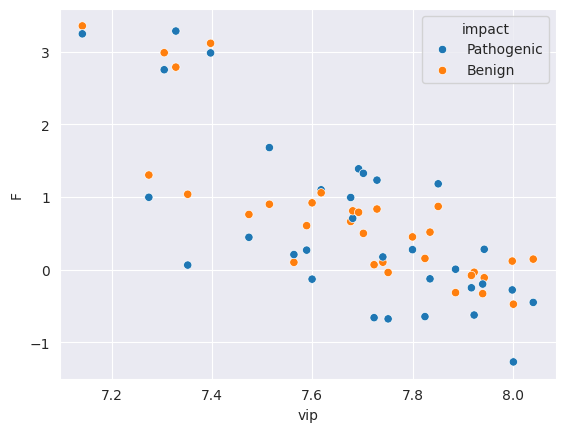

impact,context,count,vip,freq,frequencies,F
str,str,u32,f64,f64,f64,f64
"""Pathogenic""","""ACA""",6821,7.67655,0.054548,0.020188,0.993999
"""Benign""","""ACA""",42994,7.67655,0.039175,0.020188,0.662952
"""Pathogenic""","""ACC""",4691,7.8511,0.037514,0.0115,1.182349
"""Benign""","""ACC""",30156,7.8511,0.027477,0.0115,0.870986
"""Benign""","""ACG""",56233,7.3045,0.051238,0.002582,2.988025
…,…,…,…,…,…,…
"""Benign""","""TTC""",15813,7.93985,0.014408,0.02005,-0.330404
"""Benign""","""TTG""",23451,7.56325,0.021368,0.019322,0.10063
"""Pathogenic""","""TTG""",2975,7.56325,0.023791,0.019322,0.208062


In [39]:
run_analysis(clinvar_df, kmer3, "3N", "impact", ["Pathogenic", "Benign"])

## Quintuplets

Correlation
| driver    |     _ |
|-----------|-------|
| driver    | -0.54 |
| passenger | -0.76 |
Corrected correlation
| driver    |   partial_r |   p_value |
|-----------|-------------|-----------|
| driver    |       -0.42 |         0 |
| passenger |       -0.54 |         0 |


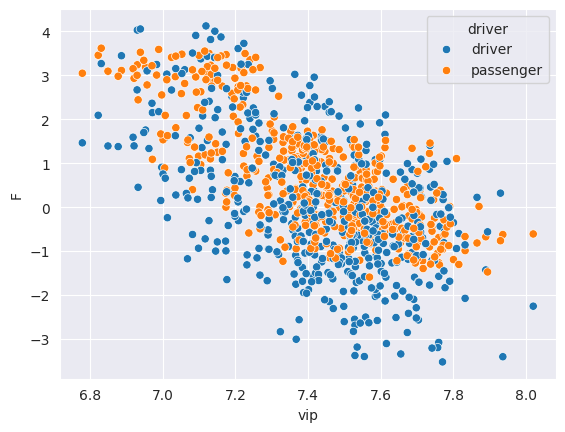

driver,context,count,vip,freq,frequencies,F
str,str,u32,f64,f64,f64,f64
"""driver""","""AACAA""",107,7.422967,0.004386,0.001929,0.821435
"""passenger""","""AACAA""",8387,7.422967,0.001622,0.001929,-0.173504
"""passenger""","""AACAC""",4821,7.532632,0.000932,0.001134,-0.196324
"""driver""","""AACAC""",5,7.532632,0.000205,0.001134,-1.711074
"""driver""","""AACAG""",152,7.386109,0.006231,0.001389,1.501167
…,…,…,…,…,…,…
"""passenger""","""TTTTC""",7179,7.831874,0.001388,0.002708,-0.668158
"""passenger""","""TTTTG""",6239,7.450801,0.001206,0.002768,-0.830576
"""driver""","""TTTTG""",31,7.450801,0.001271,0.002768,-0.778615


In [52]:
run_analysis(cmc_df, kmer5, "5N", "driver", ["driver", "passenger"])

Correlation
| impact     |     _ |
|------------|-------|
| Pathogenic | -0.7  |
| Benign     | -0.78 |
Corrected correlation
| impact     |   partial_r |   p_value |
|------------|-------------|-----------|
| Pathogenic |       -0.52 |         0 |
| Benign     |       -0.59 |         0 |


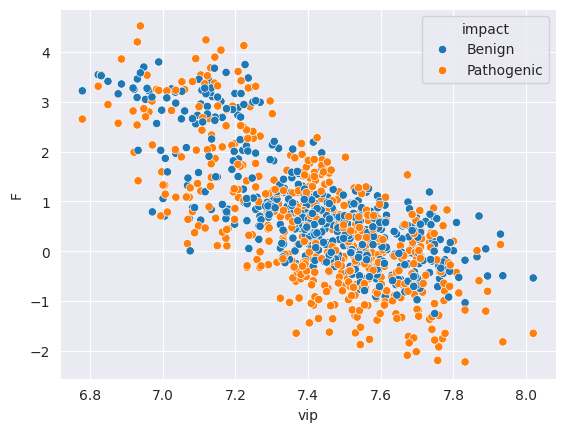

impact,context,count,vip,freq,frequencies,F
str,str,u32,f64,f64,f64,f64
"""Benign""","""AACAA""",3754,7.422967,0.003421,0.001929,0.572746
"""Pathogenic""","""AACAA""",512,7.422967,0.004095,0.001929,0.752594
"""Benign""","""AACAC""",2594,7.532632,0.002364,0.001134,0.734007
"""Pathogenic""","""AACAC""",73,7.532632,0.000584,0.001134,-0.664388
"""Benign""","""AACAG""",3899,7.386109,0.003553,0.001389,0.939325
…,…,…,…,…,…,…
"""Benign""","""TTTTC""",2481,7.831874,0.002261,0.002708,-0.180545
"""Pathogenic""","""TTTTG""",154,7.450801,0.001232,0.002768,-0.809986
"""Benign""","""TTTTG""",2442,7.450801,0.002225,0.002768,-0.218467


In [42]:
run_analysis(clinvar_df, kmer5, "5N", "impact", ["Pathogenic", "Benign"])